In [1]:
import cv2
import numpy as np
import os
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD, Adam
from matplotlib import pyplot as plt
import keras

cat_dir = 'cat_images/'
dog_dir = 'dog_images/'
SIZE = (100, 100)
TRAIN_RATIO = 0.8
RESHAPED = 0
NB_CLASSES = 2
OPTIMIZER = SGD()
BATCH_SIZE = 130
NB_EPOCH = 100
VALIDATION_SPLIT = 0.4
VERBOSE = 1
def prepare_data():
    # 猫(0)と犬(1)の画像を取得してフラグを追加したにシャッフル加工してデータとして返す。
    
    images = []
    answers = []
    cat_images = os.listdir(cat_dir)
    for cat_image in cat_images:
        if cat_image.endswith('.jpg'):
            images.append(resize_for_model(cv2.imread(cat_dir + cat_image)))
            answers.append(0)
    dog_images = os.listdir(dog_dir)
    for dog_image in dog_images:
        if dog_image.endswith('.jpg'):
            images.append(resize_for_model(cv2.imread(dog_dir + dog_image)))
            answers.append(1)
    
    images = np.array(images)
    answers = np.array(answers)
    # imagesとanswersの関係保ったままシャッフル
    random_idxs = np.random.permutation(len(images))
    images = images[random_idxs]
    answers = answers[random_idxs]
    # train_data, test_dataに分ける
    border = int(len(images) * TRAIN_RATIO)
    
    return (images[:border], answers[:border]), (images[border:], answers[border:])

def resize_for_model(image):
    # np形式のimageを特定の大きさにresizeする。
    return cv2.resize(image, SIZE)

if __name__ == '__main__':
    (X_train, y_train), (X_test, y_test) = prepare_data()
    print(len(X_train), 'X_train amount')
    print(len(X_test), 'X_test amount')
    print(X_train.shape, 'X_train shape')
    print(X_test.shape, 'X_test shape')
    SHAPE = (X_train.shape[1], X_train.shape[2], X_train.shape[3])


Using TensorFlow backend.


272 X_train amount
68 X_test amount
(272, 100, 100, 3) X_train shape
(68, 100, 100, 3) X_test shape


In [2]:
# # debug
# idx = 3
# plt.imshow(X_train[idx])
# plt.show()
# print(y_train[idx])

In [3]:
# X_train = X_train.reshape(140, RESHAPED)
# X_test = X_test.reshape(60, RESHAPED)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

In [4]:
Y_train = np_utils.to_categorical(y_train, NB_CLASSES)
Y_test = np_utils.to_categorical(y_test, NB_CLASSES)


In [5]:
# model = Sequential()
# model.add(Dense(1, input_shape=(RESHAPED,))) #Dense引数1つ目は出力数
# # model.add(Dense(16))
# # model.add(Dense(2))
# model.add(Activation('relu'))
# model.summary()

In [6]:
#参考: https://keras.io/getting-started/sequential-model-guide/
model = Sequential()
# input: 100x100 images with 3 channels -> (100, 100, 3) tensors.
# this applies 32 convolution filters of size 3x3 each.
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=SHAPE))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.6)) #無い方が振れ幅小さい

#この層無い方がマシっぽい
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.6)) #無い方が良い
model.add(Dense(NB_CLASSES, activation='softmax'))

In [7]:
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-5), metrics=['accuracy'])

In [8]:
history = model.fit(X_train, Y_train, batch_size=BATCH_SIZE, epochs=NB_EPOCH, verbose=VERBOSE, validation_split=VALIDATION_SPLIT)

Train on 163 samples, validate on 109 samples
Epoch 1/100
163/163 [==============================] - 4s 26ms/step - loss: 0.7025 - acc: 0.4663 - val_loss: 0.7024 - val_acc: 0.5321
Epoch 2/100
163/163 [==============================] - 4s 22ms/step - loss: 0.6721 - acc: 0.5828 - val_loss: 0.7259 - val_acc: 0.4771
Epoch 3/100
163/163 [==============================] - 4s 22ms/step - loss: 0.6984 - acc: 0.4969 - val_loss: 0.7014 - val_acc: 0.4587
Epoch 4/100
163/163 [==============================] - 4s 22ms/step - loss: 0.6665 - acc: 0.5951 - val_loss: 0.7005 - val_acc: 0.5413
Epoch 5/100
163/163 [==============================] - 4s 22ms/step - loss: 0.6537 - acc: 0.6135 - val_loss: 0.7087 - val_acc: 0.5505
Epoch 6/100
163/163 [==============================] - 4s 22ms/step - loss: 0.6554 - acc: 0.5951 - val_loss: 0.7077 - val_acc: 0.5505
Epoch 7/100
163/163 [==============================] - 4s 22ms/step - loss: 0.6468 - acc: 0.6135 - val_loss: 0.6986 - val_acc: 0.5780
Epoch 8/100
163/

163/163 [==============================] - 4s 22ms/step - loss: 0.3910 - acc: 0.9018 - val_loss: 0.7141 - val_acc: 0.5872
Epoch 62/100
163/163 [==============================] - 3s 21ms/step - loss: 0.3903 - acc: 0.8957 - val_loss: 0.7132 - val_acc: 0.5780
Epoch 63/100
163/163 [==============================] - 4s 22ms/step - loss: 0.3827 - acc: 0.9141 - val_loss: 0.7202 - val_acc: 0.6055
Epoch 64/100
163/163 [==============================] - 3s 21ms/step - loss: 0.3851 - acc: 0.8896 - val_loss: 0.7132 - val_acc: 0.5780
Epoch 65/100
163/163 [==============================] - 4s 22ms/step - loss: 0.3745 - acc: 0.9325 - val_loss: 0.7165 - val_acc: 0.5229
Epoch 66/100
163/163 [==============================] - 4s 24ms/step - loss: 0.3839 - acc: 0.9080 - val_loss: 0.7189 - val_acc: 0.5138
Epoch 67/100
163/163 [==============================] - 4s 22ms/step - loss: 0.3805 - acc: 0.9141 - val_loss: 0.7115 - val_acc: 0.5688
Epoch 68/100
163/163 [==============================] - 4s 22ms/step

In [9]:
score = model.evaluate(X_test, Y_test, verbose=VERBOSE)
print('Test score:', score[0])
print('Test acc:', score[1])

68/68 [==============================] - 0s 7ms/step
Test score: 0.654067740720861
Test acc: 0.5735294117647058


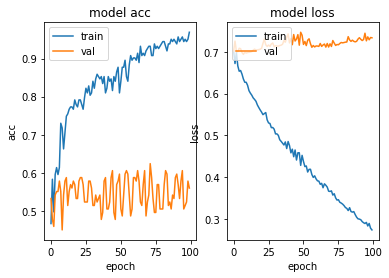

In [10]:
plt.subplot(121)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

train_dataのacc, lossは順調に推移するが、val_dataに対しては一定幅で同水準に留まる。
元データが少ないから？(https://datascience.stackexchange.com/questions/37815/what-to-do-if-training-loss-decreases-but-validation-loss-does-not-decrease)